# Project-1: Sentiment Analysis of Amazon Reviews

In this project, sentiment analysis was performed on user reviews from the **All Beauty**, **Digital Music**, and **Health and Personal Care** categories in the Amazon marketplace for the year 2023.

The project includes text cleaning and preprocessing steps. A **Logistic Regression** model and a **Deep learning model with LSTM and a self-attention mechanism** model were created for sentiment analysis.

The generated models were used to create a **sentiment** column from the reviews. By combining the **rating** scores of the sellers with the sentiment results, an analysis of the most appreciated sellers was conducted.

sentiment analysis using Amazon reviews can provide valuable insights into customer preferences and the success of e-commerce stores. By analyzing sentiments, ratings, and store performance, businesses can make data-driven decisions to improve their customer experiences and increase their overall revenue.

The study was conducted on an AWS `g5.2xlarge` GPU-optimized spot instance. The data was uploaded to `AWS S3` and then fetched to the spot EC2 instance for processing.


# Data Specifications

| Category                  | #User   | #Item   | #Rating  | #R_Token | #M_Token |
|---------------------------|---------|---------|----------|----------|----------|
| All_Beauty               | 632.0K  | 112.6K  | 701.5K   | 31.6M    | 74.1M    |
| Digital_Music            | 101.0K  | 70.5K   | 130.4K   | 11.4M    | 22.3M    |
| Health_and_Personal_Care | 461.7K  | 60.3K   | 494.1K   | 23.9M    | 40.3M    |

[Data Source](https://amazon-reviews-2023.github.io/)


## Table of Contents

- [1. Data Loading and Validation](#1-data-loading-and-validation)
- [2. Data Preparation for Sentiment Analysis](#2-data-preparation-for-sentiment-analysis)
  - [2.1. Removing Duplicate Values](#21-removing-duplicate-values)
  - [2.2. Data Labeling](#22-data-labeling)
  - [2.3. Selecting Necessary Features](#23-selecting-necessary-features)
- [3. Text Preprocessing for Sentiment Analysis](#3-text-preprocessing-for-sentiment-analysis)
  - [3.1. Text Cleaning](#31-text-cleaning)
  - [3.2. Remove Stopwords](#32-remove-stopwords)
  - [3.3. Remove Rarewords](#33-remove-rarewords)
  - [3.4. Lemmatization](#34-lemmatization)
  - [3.5. Text Preprocessing Function](#35-text-preprocessing-function)
- [4. Exploratory Data Analysis](#4-exploratory-data-analysis)
  - [4.1. Countplot of Target Variable Sentiment](#41-countplot-of-target-variable-sentiment)
  - [4.2. WordCloud of Each Category](#42-wordcloud-of-each-category)
- [5. Sentiment Modeling](#5-sentiment-modeling)
  - [5.1. Logistic Regression + TFIDF Vectorization](#51-logistic-regression--tfidf-vectorization)
    - [5.1.1. Binary Encoding For Sentiment Labelling](#511-binary-encoding-for-sentiment-labelling)
    - [5.1.2. Split Data as Train and Test](#512-split-data-as-train-and-test)
    - [5.1.3. Term Frequency-Inverse Document Frequency (TF-IDF) Vectorization](#513-term-frequency-inverse-document-frequency-tf-idf-vectorization)
    - [5.1.4. Hyperparameter Tuning](#514-hyperparameter-tuning)
    - [5.1.5. Model Training and Evaluation](#515-model-training-and-evaluation)
    - [5.1.6. Prediction](#516-prediction)
  - [5.2.Sentiment Analysis with Deep Learning CNN & LSTM & Multi head Self Attention Model](#52-sentiment-analysis-with-deep-learning-cnn-&-lstm-&-multi-head-self-attention-model)
    - [5.2.1. Data Preparation and Binary Encoding For Sentiment Labelling](#521-data-preparation-and-binary-encoding-for-sentiment-labelling)
    - [5.2.2. Text Cleaning](#522-text-cleaning)
    - [5.2.3. Split Data as Train and Test](#523-split-data-as-train-and-test)
    - [5.2.4. Tokenization and Word Embeddings](#524-tokenization-and-word-embeddings)
    - [5.2.5. Model Training and Evaluation](#525-model-training-and-evaluation)
    - [5.2.6. Prediction](#526-prediction)
- [6. Store Performance Analysis Based on Sentiment Analysis](#6-store-performance-analysis-based-on-sentiment-analysis)
- [7. Conclusion](#7-conclusion)

In [41]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import Union, Dict, Tuple, List
from sklearn.base import BaseEstimator
import boto3
from io import BytesIO

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word

import tensorflow as tf
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Layer,  BatchNormalization, Bidirectional, LayerNormalization, MultiHeadAttention, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.optimizers import Adam

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)

plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))
tqdm.pandas()

In [19]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.18.0
GPU is available


# 1. Data loading and Validation

The datasets containing Amazon reviews from three different categories have been downloaded from the source link, and the row counts have been verified. The `All Beauty` category contains `701528` records, the `Digital Music` category contains `130434` records, and the `Health and Personal Care` category contains `494121` records.

A missing value check was performed, and no missing data was found. Since duplicate text data is not desired for sentiment analysis, duplicate text records were also checked. Accordingly, the `All Beauty` category contains `57899` duplicate records, the `Digital Music` category contains `11789` duplicate records, and the `Health and Personal Care` category contains `39085` duplicate records. Additionally, a `category` column has been added to the datasets.


**Loading from Local**

In [72]:
all_beauty_review_file_path = "./data/all_beauty/All_Beauty.jsonl.gz"
digital_music_review_file_path = "./data/digital_music/Digital_Music.jsonl.gz"
health_and_personal_care_review_file_path = "./data/health_and_personal_care/Health_and_Personal_Care.jsonl.gz"

all_beauty_review_df = pd.read_json(all_beauty_review_file_path, lines=True, compression="gzip")
digital_music_review_df = pd.read_json(digital_music_review_file_path, lines=True, compression="gzip")
health_and_personal_care_review_df = pd.read_json(health_and_personal_care_review_file_path, lines=True,compression="gzip")

all_beauty_review_df["category"] = "all_beauty"
digital_music_review_df["category"] = "digital_music"
health_and_personal_care_review_df["category"] = "health_and_personal_care"

print("# Missing value check of each dataset:\n")
names = ["all_beauty_review_df", "digital_music_review_df", "health_and_personal_care_review_df"]
dataframes = [all_beauty_review_df, digital_music_review_df, health_and_personal_care_review_df]

for name, df in zip(names, dataframes):
    print(f"Missing values in the {name} dataset: {df.isnull().sum().sum()}")
    print(50 * "-")

print("# Shape check of each dataset:\n")
for name, df in zip(names, dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print("# Duplicate check on 'text' feature of each dataset:\n")
for name, df in zip(names, dataframes):
    print(f"Duplicate values in the text feature of the {name} dataset: {df[df["text"].duplicated(keep="first")].shape[0]}")
    print(50 * "-")

print(50 * "*")
data = pd.concat([all_beauty_review_df, digital_music_review_df, health_and_personal_care_review_df], axis= 0)
df = data.copy()
print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {df.shape}")
print(50 * "*")


**Loading from AWS S3**

In [20]:
s3_bucket_name = "kntbucket2"
s3_all_beauty_path = "data/all_beauty/All_Beauty.jsonl.gz"
s3_digital_music_path = "data/digital_music/Digital_Music.jsonl.gz"
s3_health_and_personal_care_path = "data/health_and_personal_care/Health_and_Personal_Care.jsonl.gz"

s3_client = boto3.client("s3",region_name="eu-central-1")

def read_s3_jsonl(bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    compressed_data = response["Body"].read()
    return pd.read_json(BytesIO(compressed_data), lines=True, compression="gzip")


all_beauty_review_df = read_s3_jsonl(s3_bucket_name, s3_all_beauty_path)
digital_music_review_df = read_s3_jsonl(s3_bucket_name, s3_digital_music_path)
health_and_personal_care_review_df = read_s3_jsonl(s3_bucket_name, s3_health_and_personal_care_path)


all_beauty_review_df["category"] = "all_beauty"
digital_music_review_df["category"] = "digital_music"
health_and_personal_care_review_df["category"] = "health_and_personal_care"


print("# Missing value check of each dataset:\n")
names = ["all_beauty_review_df", "digital_music_review_df", "health_and_personal_care_review_df"]
dataframes = [all_beauty_review_df, digital_music_review_df, health_and_personal_care_review_df]

for name, df in zip(names, dataframes):
    print(f"Missing values in the {name} dataset: {df.isnull().sum().sum()}")
    print(50 * "-")

print("# Shape check of each dataset:\n")
for name, df in zip(names, dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print("# Duplicate check on 'text' feature of each dataset:\n")
for name, df in zip(names, dataframes):
    if "text" in df.columns:
        duplicated = df[df['text'].duplicated(keep='first')].shape[0]
        print(f"Duplicate values in the text feature of the {name} dataset: {duplicated}")
    else:
        print(f"No 'text' feature in the {name} dataset.")
    print(50 * "-")

print(50 * "*")
data = pd.concat([all_beauty_review_df, digital_music_review_df, health_and_personal_care_review_df], axis=0)
df = data.copy()
print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {df.shape}")
print(50 * "*")

# Missing value check of each dataset:

Missing values in the all_beauty_review_df dataset: 0
--------------------------------------------------
Missing values in the digital_music_review_df dataset: 0
--------------------------------------------------
Missing values in the health_and_personal_care_review_df dataset: 0
--------------------------------------------------
# Shape check of each dataset:

Shape of the all_beauty_review_df dataset: (701528, 11)
--------------------------------------------------
Shape of the digital_music_review_df dataset: (130434, 11)
--------------------------------------------------
Shape of the health_and_personal_care_review_df dataset: (494121, 11)
--------------------------------------------------
# Duplicate check on 'text' feature of each dataset:

Duplicate values in the text feature of the all_beauty_review_df dataset: 57899
--------------------------------------------------
Duplicate values in the text feature of the digital_music_review_df datas

In [4]:
df["category"].value_counts().reset_index()

,category,count
0,all_beauty,701528
1,health_and_personal_care,494121
2,digital_music,130434


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1326083 entries, 0 to 494120
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   rating             1326083 non-null  int64         
 1   title              1326083 non-null  object        
 2   text               1326083 non-null  object        
 3   images             1326083 non-null  object        
 4   asin               1326083 non-null  object        
 5   parent_asin        1326083 non-null  object        
 6   user_id            1326083 non-null  object        
 7   timestamp          1326083 non-null  datetime64[ns]
 8   helpful_vote       1326083 non-null  int64         
 9   verified_purchase  1326083 non-null  bool          
 10  category           1326083 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(7)
memory usage: 112.6+ MB


# 2. Data Preparation for Sentiment Analysis

## 2.1. Removing duplicate values

As shown in the example below ("Love it"), using duplicate data in the modeling process would create unnecessary information and increase model complexity. Therefore, all records containing duplicate text data have been removed.

In [6]:
df[df["text"].duplicated(keep="first")].head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,category
116,5,Works very well,Works very well,[],B08SWV1X6D,B08SWV1X6D,AGYBOBPV47L6FRILNSZ7S6XFLPFA,2022-04-20 22:32:17.328,0,True,all_beauty
375,2,Band too wide,"The lashed are pretty but the band is too wide, it covers too much of the eyelid. Also the way it's packaged makes it difficult to remove from plastic casing and tears the lash strip.",[],B09QSLMPR5,B09QSLMPR5,AHI7SBHYECQUIS63BKXBHY325VVQ,2022-05-29 02:09:12.450,0,True,all_beauty
415,5,Awesome,Love it,[],B0881FJSHT,B0881FJSHT,AGZZ35KI6RBFZYHG4TZPOAIACVMA,2021-04-19 18:34:24.713,0,True,all_beauty
593,5,Five Stars,great,[],B01N2VTZCC,B01N2VTZCC,AHNZGXDDP6KMIZ3JWII47NK72OLA,2017-06-15 13:18:07.670,0,True,all_beauty
619,5,Holds up well,Love it,[],B018681Q64,B018681Q64,AHEVUFDDDQV4763ZYIA745KOXUUA,2021-03-14 01:06:54.760,0,True,all_beauty


In [5]:
df.drop_duplicates(subset="text",keep="first",inplace=True)
df.shape

(1208405, 11)

## 2.2. Data Labeling

At this stage, a sentiment variable has been created, and reviews with `rating >= 3` havel been labeled as `positive`, while reviews with `Rating < 3` have been labeled as `negative`. Accordingly, there are `966661` positive and `241744` negative reviews in the dataframe.

In [6]:
df["sentiment"] = np.where(df["rating"] >= 3, "positive", "negative")
df["sentiment"].value_counts().reset_index()

,sentiment,count
0,positive,966661
1,negative,241744


## 2.3. Selecting Necessary Features

In [7]:
df = df[["parent_asin","rating","text","category","sentiment"]]

# 3. Text Preprocessing for Sentiment Analysis

## 3.1. Text Cleaning

Due to its adverse effect on model performance, unwanted punctuation marks, parentheses, special characters, HTML tags, numbers, and extra spaces have been removed from the comments, and all characters have been converted to lowercase to achieve a clean format.


In [8]:
df.iloc[154:157]

,parent_asin,rating,text,category,sentiment
155,B07DSQ3NWM,5,Not greasy or filmy!<br />Love the look and feel of this lightweight moisturizer! Don’t use too much!<br />Skin feels amazing every morning when I wake up!,all_beauty,positive
156,B0792Q3T59,5,"I have been using this mascara for about 2 months now and I am in awe at the difference in my lashes. And I’ve used it all! I’ve tried so many types of mascara even went thru falsies, extensions. And I love this product. It lengthens, plumps, and makes my lashes LOOK healthier. I highly recommend!",all_beauty,positive
157,B01NCWHH2W,5,"These along with their other scents (I love the blue ones too) are a must. I’m a face mask and product collector, I have so many masks but these are my top sheet masks for sure!!",all_beauty,positive


In [21]:
def clean_text(text: str) -> str:
    """
    Clean and normalize text by removing HTML tags, punctuation, numbers, emojis, parentheses, 
    and extra whitespace.

    Parameters
    ----------
    text : str
        The input text string to be cleaned.

    Returns
    -------
    str
        The cleaned and normalized text string.
    
    Notes
    -----
    This function performs the following operations:
        - Converts the text to lowercase.
        - Removes HTML tags.
        - Removes punctuation and parentheses.
        - Removes numbers.
        - Collapses multiple spaces into a single space and strips.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags 
    text = re.sub(r"<.*?>", " ", text)

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Remove numbers
    text = re.sub(r"\d", "", text)
    
    # Collapse multiple spaces into a single space and strips
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

In [10]:
df["text"] = df["text"].progress_apply(clean_text)
df.iloc[154:157]

100%|██████████████████████████████████████████████████████████████████████████| 1208405/1208405 [00:23<00:00, 50954.13it/s]


,parent_asin,rating,text,category,sentiment
155,B07DSQ3NWM,5,not greasy or filmy love the look and feel of this lightweight moisturizer dont use too much skin feels amazing every morning when i wake up,all_beauty,positive
156,B0792Q3T59,5,i have been using this mascara for about months now and i am in awe at the difference in my lashes and ive used it all ive tried so many types of mascara even went thru falsies extensions and i love this product it lengthens plumps and makes my lashes look healthier i highly recommend,all_beauty,positive
157,B01NCWHH2W,5,these along with their other scents i love the blue ones too are a must im a face mask and product collector i have so many masks but these are my top sheet masks for sure,all_beauty,positive


## 3.2. Remove Stopwords

Stopword removal is the process of eliminating common, non-informative words (e.g., "and", "the", "for") from a text to help models focus on more meaningful content.

In [14]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
sw = stopwords.words("english")
df["text"] = df["text"].progress_apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

100%|██████████████████████████████████████████████████████████████████████████| 1208405/1208405 [00:43<00:00, 27504.54it/s]


## 3.3. Remove Rarewords

It is undesirable to keep infrequently occurring words in the study. If a word appears once or twice in the dataset. It can make it more difficult for the model to learn and increases its complexity. Therefore, their removal is beneficial.

In [12]:
temp_df = pd.Series(" ".join(df["text"]).split()).value_counts().sort_values(ascending=True)
temp_df.head()

juvey                1
origin_morocco       1
asinbsedw            1
videoiddbefffbbda    1
geneticist           1
Name: count, dtype: int64

A threshold of 1000 words has been selected. Words with a frequency of less than 1000 have been removed from the dataset.

In [13]:
rare_words = pd.Series(" ".join(df["text"]).split()).value_counts()[-1000:]
df["text"] = df["text"].progress_apply(lambda x: " ".join(x for x in str(x).split() if x not in rare_words))

100%|██████████████████████████████████████████████████████████████████████████| 1208405/1208405 [00:41<00:00, 28787.77it/s]


## 3.4. Lemmatization

Lemmatization is the process of reducing a word to its base or dictionary form (lemma), ensuring that different forms of a word (e.g., "running," "ran," "runs") are represented by a single, standardized version, which helps improve the accuracy of natural language processing tasks.

In [18]:
# nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...


True

In [14]:
df["text"] = df["text"].progress_apply(lambda x : " ".join(Word(word).lemmatize() for word in str(x).split()))
df.iloc[154:157]

100%|██████████████████████████████████████████████████████████████████████████| 1208405/1208405 [01:44<00:00, 11606.28it/s]


,parent_asin,rating,text,category,sentiment
155,B07DSQ3NWM,5,greasy filmy love look feel lightweight moisturizer dont use much skin feel amazing every morning wake,all_beauty,positive
156,B0792Q3T59,5,using mascara month awe difference lash ive used ive tried many type mascara even went thru falsie extension love product lengthens plump make lash look healthier highly recommend,all_beauty,positive
157,B01NCWHH2W,5,along scent love blue one must im face mask product collector many mask top sheet mask sure,all_beauty,positive


## 3.5. Text Preporocess Function

A function has been written to encompass all the processes mentioned above.

In [15]:
def text_preprocessing(df: pd.DataFrame, sentiment_feature: str, remove_rare_words:bool=False) -> pd.DataFrame:
    """Preprocess text data for sentiment analysis.

    This function performs several preprocessing steps on the specified text column
    of a pandas DataFrame, including cleaning the text, removing duplicates, 
    filtering out stopwords, eliminating rare words, and lemmatizing the text.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the text data to be preprocessed.
    sentiment_feature : str
        The name of the column in the DataFrame that contains the text data.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the preprocessed text data in the specified sentiment feature column.
    
    Notes
    -----
    The function checks if the 'wordnet' resource is downloaded; if not, it downloads it.
    """
    # For Progress bar
    tqdm.pandas()
    
    # Downloads for WordNet and Stopwords
    nltk.download('stopwords')
    nltk.download("wordnet")
    
    
    # Revove missing values and Duplicates
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    
    # Clean text
    df[sentiment_feature] = df[sentiment_feature].progress_apply(clean_text)
    
    
    # Remove Stopwords
    sw = stopwords.words("english")
    df[sentiment_feature] = df[sentiment_feature].progress_apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    
    # Remove rare words if it true
    if remove_rare_words:
            rare_words = pd.Series(" ".join(df[sentiment_feature]).split()).value_counts()[-1000:]
            df[sentiment_feature] = df[sentiment_feature].progress_apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))
    
    # Lemmatize the text
    df[sentiment_feature] = df[sentiment_feature].progress_apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
    
    
    return df

## 4. Exploratory data analysis

## 4.1. Countplot of Target Variable Sentiment

The dataset contains 96661 positive reviews and 241744 negative reviews. The class imbalance problem appears.

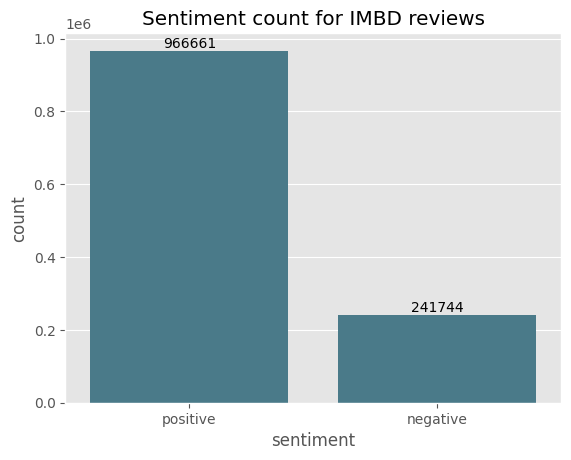

In [26]:
ax = sns.countplot(data=df, x = "sentiment")
plt.title("Sentiment count for IMBD reviews")
ax.bar_label(ax.containers[0], fmt="%d")
plt.show()

## 4.2. WordCloud of Each Category

A word cloud is a visual representation of the frequency of words in a text. Words that appear more frequently are displayed in larger fonts, while less frequent words are shown in smaller sizes. It is commonly used to quickly identify prominent terms in a dataset, offering a simple way to visualize the importance or repetition of certain words in a document or collection of texts. A word cloud has been created for each category.

In [23]:
def generate_word_cloud(df: pd.DataFrame, 
                        column: str,
                        max_font_size: int = 50,
                        max_words: int = 100,
                        background_color: str = "black",
                        interpolation: str = "bilinear") -> None:
    """
    Generate and display a word cloud from the text in a specified column of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the text data.
    column : str
        The name of the column from which the text data will be used to generate the word cloud.
    max_font_size : int, optional
        The maximum font size for the largest word in the word cloud (default is 50).
    max_words : int, optional
        The maximum number of words to be included in the word cloud (default is 100).
    background_color : str, optional
        The background color of the word cloud (default is "black").
    interpolation : str, optional
        The interpolation method used for displaying the word cloud (default is "bilinear").

    Returns
    -------
    None
        Displays the word cloud as a plot.

    """
    text = " ".join(text for text in df[column])
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation=interpolation)
    plt.axis("off")
    plt.show()

all_beauty category:


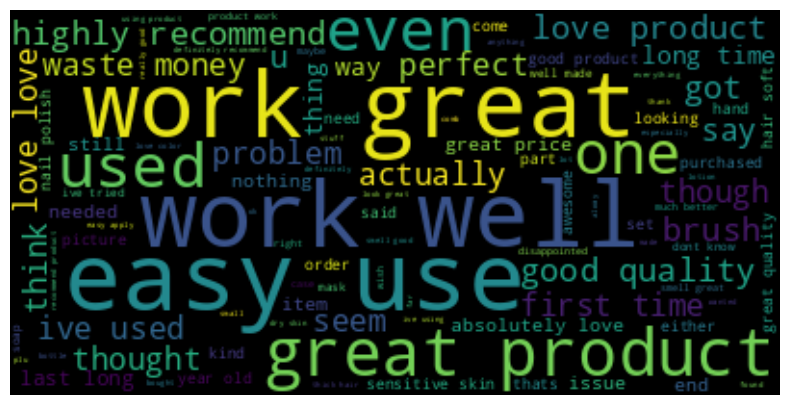

**************************************************
digital_music category:


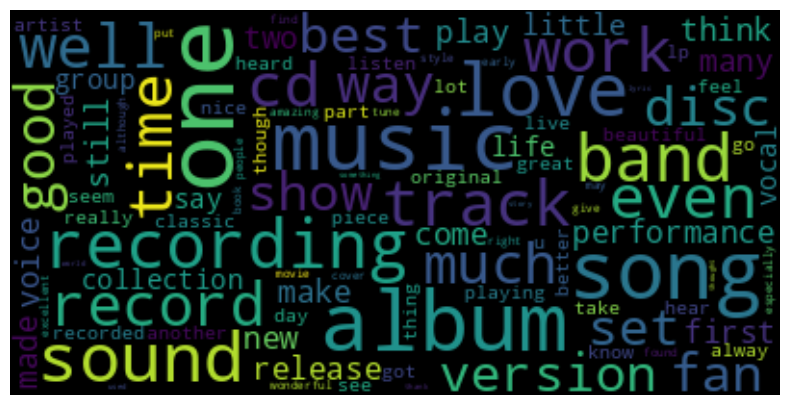

**************************************************
health_and_personal_care category:


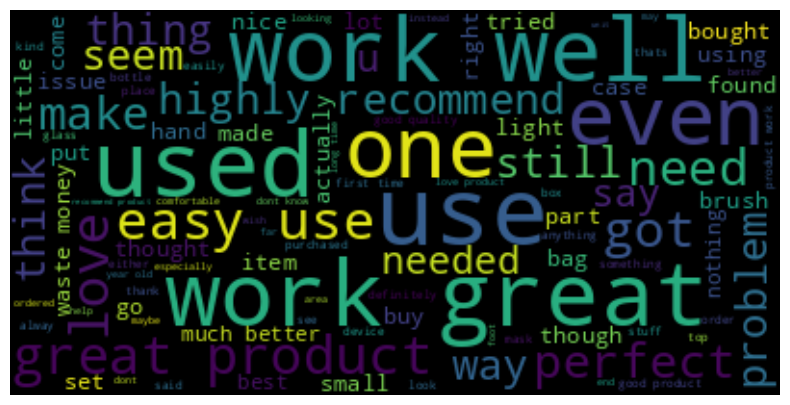

**************************************************


In [24]:
categories =df["category"].unique().tolist()
for category in categories:
    print(f"{category} category:")
    generate_word_cloud(df=df[df["category"]==category], column="text", max_words=100)
    print(50 * "*")

# 5. Sentiment Modeling

In this section, two different types of models will be developed for sentiment analysis, and two different word vectorization techniques will be applied.

1. Logistic Regression + TFIDF Vectorization  
2. BERT Fine-Tuning + Word Embeddings  

**Logistic Regression:**  
Logistic regression is a statistical model used for binary classification tasks, where the goal is to determine the probability that a given input belongs to one of two classes. It predicts outcomes using a logistic (sigmoid) function, making it suitable for modeling relationships between input features and a binary target variable.  

**TF-IDF Vectorization:**  
TF-IDF (Term Frequency-Inverse Document Frequency) is a technique that represents text data by assigning weights to words based on their frequency in a document relative to their occurrence across all documents. It helps emphasize important words in a document while reducing the impact of commonly occurring terms.  

**BERT:**  
BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that understands the context of words by analyzing both left and right directions in a sentence. By fine-tuning BERT, it can achieve state-of-the-art results for various NLP tasks, including sentiment analysis.  

**Word Embeddings:**  
Word embeddings are dense vector representations of words where similar words are mapped closer in a multidimensional space. These embeddings are learned from large text corpora and capture semantic relationships between words effectively. 

## 5.1. Logistic Regression + TFIDF Vectorization 

There are `966661 positive` and `241744 negative` reviews in the dataframe. Due to this class imbalance, `SMOTE` might seem like a solution; however, it is not suitable for text data. Although words are converted into numerical representations, these are word vectors that capture semantic relationships. SMOTE works by interpolating numerical data, which can distort these semantic relationships and lead to inconsistent or meaningless results. Additionally, it does not preserve the structural integrity of the text. Therefore, the class imbalance problem will be addressed using `class_weight='balanced'` , which adjusts the weights of the classes automatically, ensuring that the minority class has a greater influence during model training in Logistic Regression model.



### 5.1.1. Binary Encoding For Sentiment Labelling

The sentiment label is currently represented as a string ("positive" or "negative"). We will convert this into a binary representation, where 1 represents positive sentiment and 0 represents negative sentiment.

In [16]:
df["sentiment"] = np.where(df["sentiment"]=="positive", 1, 0)
df["sentiment"].value_counts().reset_index()

,sentiment,count
0,1,966661
1,0,241744


### 5.1.2. Split Data as Train and Test

The dataset will be split into 80% training and 20% testing, and the stratify=y parameter ensures fair class representation by preserving the class distribution in both the training and test sets, and the data will also be shuffled with shuffle=True.

In [17]:
feature = "text"
target = "sentiment"
X = df[feature]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (966724,), X_test shape: (241681,)
y_train shape: (966724,), y_test shape: (241681,)


### 5.1.3. Term Frequency-Inverse Document Frequency (TF-IDF) Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) is a technique that represents text data by assigning weights to words based on their frequency in a document relative to their occurrence across all documents. It helps emphasize important words in a document while reducing the impact of commonly occurring terms. 

In [18]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)
x_train_tfidf = tfidf_vectorizer.transform(X_train)
x_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"x_train_tfidf shape: {x_train_tfidf.shape}, X_test shape: {X_test.shape}")
print(f"x_test_tfidf shape: {x_test_tfidf.shape}, y_test shape: {y_test.shape}")

x_train_tfidf shape: (966724, 273553), X_test shape: (241681,)
x_test_tfidf shape: (241681, 273553), y_test shape: (241681,)


### 5.1.4. Hyperparameter Tuning

In [5]:
# log_reg = LogisticRegression()
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# param_grid = {
#     'penalty': ['l1', 'l2'],  
#     'C': [0.01, 0.1, 1, 10],  
#     'solver': ['liblinear', 'saga']
# }
# grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

# grid_search.fit(x_train_tfidf, y_train)

# print("Best Parameters:", grid_search.best_params_)
# y_pred = grid_search.best_estimator_.predict(x_test_tfidf)

# f1 = f1_score(y_test, y_pred)
# print(f"F1 Score: {f1}")

### 5.1.5. Model Training and Evaluation

F1 score performance metric has been chosen for evaluation of the model which is the harmonic avarage of the recall and precision scores. The model performed %91 Cross train validation f1-score and %91 on test data.

In [27]:
def train_and_evaluate_model(
    model: BaseEstimator,
    x_train: pd.DataFrame,
    y_train: pd.Series,
    x_test: pd.DataFrame,
    y_test: pd.Series,
    scoring: str,
    scoring_func: callable,
    cv_type: int
) -> BaseEstimator:
    """Train and evaluate a machine learning model.

    This function fits the model on the training data, performs cross-validation
    to evaluate its performance, makes predictions on the test data, calculates
    the final score using a specified scoring function, and visualizes the
    confusion matrix.

    Parameters
    ----------
    model : BaseEstimator
        The machine learning model to be trained.
    x_train : pd.DataFrame
        Feature data for training.
    y_train : pd.Series
        Target data for training.
    x_test : pd.DataFrame
        Feature data for testing.
    y_test : pd.Series
        Target data for testing.
    scoring : str
        The scoring metric to evaluate the model during cross-validation.
    scoring_func : callable
        A function to calculate the final score based on true and predicted labels.
    cv_type : int
        The number of cross-validation folds.

    Returns
    -------
    BaseEstimator
        The trained machine learning model.
    """

    trained_model = model.fit(x_train, y_train)
    result_cv_score = cross_val_score(trained_model, x_train, y_train, scoring=scoring, cv=cv_type).mean()
    y_pred = trained_model.predict(x_test)
    result_final_score = scoring_func(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Train cross validation score: {result_cv_score:.2f}")
    print(f"Final test score: {result_final_score:.2f}")

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return model

Train cross validation score: 0.91
Final test score: 0.91


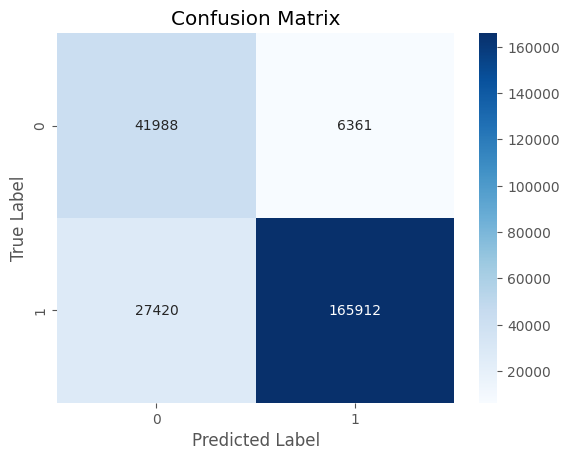

In [28]:
lr_model_tfidf = LogisticRegression(C= 1, penalty="l2", solver="lbfgs", class_weight="balanced")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model = train_and_evaluate_model(lr_model_tfidf, x_train_tfidf, y_train, x_test_tfidf, y_test, "f1", f1_score, skf)

### 5.1.6. Prediction

In this section, syntetic reviews generated using LLM Model for prediction performance of the trainned model. The model has been predicted all the syntetic reviews as %100 percentage.

- There are 1 positive and 1 negative reviews for each category.
- First 2 list item belonging to the all beauty category, first review positive and second review negative.
- The other 2 list item belonging to the digital music category 1 positive and 1 negative reviews
- The other 2 list item belonging to the digital health_and_personal_care category 1 positive and 1 negative reviews

In [29]:
def lr_predict_sentiment(
    model: BaseEstimator,
    vectorizer: TfidfVectorizer,
    review: str
) -> None:
    """Predict the sentiment of a given review using the specified model and vectorizer.

    This function transforms the input review using the TFIDF vectorizer, 
    makes a prediction with the given model, and prints the sentiment label.

    Parameters
    ----------
    model : BaseEstimator
        The machine learning model used for prediction.
    vectorizer : TfidfVectorizer,
        The vectorizer used to transform the input review into feature space.
    review : str
        The review text to be analyzed.

    Returns
    -------
    None
        This function prints the input review and the predicted sentiment label.
    """
    if isinstance(review, str):
        review = [review]
        
    new_review = vectorizer.transform(review)
    pred = model.predict(new_review)
    label = "positive" if pred[0] == 1 else "negative"
    # print(f"\nReview:{review[0]}\nPrediction: {label}")
    return label

In [30]:
sample_reviews = [
    "This moisturizer leaves my skin feeling soft and hydrated all day!",
    "The fragrance of this product is overwhelming and gave me a headache.",
    "This album is an absolute masterpiece with every track hitting perfectly!",
    "The sound quality of this download was terrible, full of glitches and skips.",
    "This toothbrush is amazing, my teeth feel professionally cleaned every time.",
    "The packaging was damaged, and the product was unusable upon arrival.",
]
sample_reviews_df = pd.DataFrame(sample_reviews, columns=["text"])

In [31]:
df_samples_clean= text_preprocessing(sample_reviews_df, "text")
df_samples_clean_list = pd.Series(df_samples_clean["text"]).tolist()

sentiment_predictions = []
for review in df_samples_clean_list:
    sentiment = lr_predict_sentiment(model=lr_model, vectorizer=tfidf_vectorizer, review= review)
    sentiment_predictions.append(sentiment)

sample_reviews_df["sentiment"] = sentiment_predictions
sample_reviews_df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iskorpittt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iskorpittt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 6/6 [00:00<?, ?it/s]


,text,sentiment
0,moisturizer leaf skin feeling soft hydrated day,positive
1,fragrance product overwhelming gave headache,negative
2,album absolute masterpiece every track hitting perfectly,positive
3,sound quality download terrible full glitch skip,negative
4,toothbrush amazing teeth feel professionally cleaned every time,positive
5,packaging damaged product unusable upon arrival,negative


## 5.2. Sentiment Analysis with Deep Learning CNN & LSTM & Multi head Self Attention Model

### 5.2.1. Data Preperation and Binary Encoding For Sentiment Labelling

The sentiment label is currently represented as a string ("positive" or "negative"). We will convert this into a binary representation, where 1 represents positive sentiment and 0 represents negative sentiment.

The data will be processed from scratch, so the raw version of the dataframe has been reloaded using the data.copy() method. Unnecessary features will not be used like previous works.

In [25]:
df = data.copy()
df = df[["parent_asin","rating","text","category"]]
df["sentiment"] = np.where(df["rating"] >= 3, 1, 0)
df["sentiment"].value_counts().reset_index()
df.head()

,parent_asin,rating,text,category,sentiment
0,B00YQ6X8EO,5,"This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",all_beauty,1
1,B081TJ8YS3,4,"This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)",all_beauty,1
2,B097R46CSY,5,"Smells good, feels great!",all_beauty,1
3,B09JS339BZ,1,Felt synthetic,all_beauty,0
4,B08BZ63GMJ,5,Love it,all_beauty,1


### 5.2.2. Text Cleaning

At this stage, only text cleaning operations such as removing duplicates, converting text to lowercase, removing HTML tags, and eliminating punctuation will be performed. Operations like removing stop words, eliminating rare words, and performing lemmatization are unnecessary in advanced models with attention mechanism because these models are capable of capturing contextual information directly from the raw text without the need for such preprocessing steps.

In [26]:
df.drop_duplicates(subset="text",keep="first",inplace=True)
df.dropna(axis=0, inplace=True)
df["text"] = df["text"].progress_apply(clean_text)

100%|██████████████████████████████████████████████████████████████████████████| 1208405/1208405 [00:23<00:00, 50930.72it/s]


### 5.2.3. Split Data as Train and Test

The dataset will be split into 80% training and 20% testing, and the stratify=y parameter ensures fair class representation by preserving the class distribution in both the training and test sets, and the data will also be shuffled with shuffle=True.

In [27]:
feature = "text"
target = "sentiment"
X = df[feature]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (966724,), X_test shape: (241681,)
y_train shape: (966724,), y_test shape: (241681,)


### 5.2.4. Tokenization and Word Embeddings

To train a deep learning model effectively, the first step is tokenization. This process converts text into smaller units (tokens) and assigns each token a unique numerical ID based on its frequency in the dataset. Using Keras' `Tokenizer`, we can focus on the most frequent words to optimize both the training time and model performance. For this dataset, out of a total of `248355` words, only the top `15000` most frequent ones (`max_freq_words = 15000`) are used, while less frequent words are classified as `<oov>` (out-of-vocabulary).

After tokenization, the text sequences are padded to ensure uniform length. Since reviews in the dataset vary significantly in size, Keras' `pad_sequences` function is used to add zeros to shorter sequences. The longest review contains `3262` words, but by setting the maximum sequence length to `160` (based on two standard deviations above the mean word count), we cover `97%` of the data, balancing efficiency and coverage.

To make the tokenized text meaningful for the model, word embeddings are applied. These embeddings transform the numerical tokens into dense vectors that capture semantic relationships between words. Keras' `Embedding` layer is used for this purpose, enabling the model to learn these representations during training. This preprocessing pipeline ensures that the input text data is well-prepared for training a deep learning model.


In [28]:
max_freq_words = 15000
tokenizer = Tokenizer(num_words = max_freq_words, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
total_vocabulary_size = len(word_index)
print(f"Total vocabulary of the dataset is : {total_vocabulary_size}")

Total vocabulary of the dataset is : 286733


In [29]:
train_review_sequences = tokenizer.texts_to_sequences(X_train)
test_review_sequences =  tokenizer.texts_to_sequences(X_test)

In [30]:
total_review_sequences_length_list = [len(i) for i in train_review_sequences + test_review_sequences]
max_review_sequence=max(total_review_sequences_length_list)
print(f"Maximum length of review sequence in the list is {max_review_sequence}")

Maximum length of review sequence in the list is 3262


In [31]:
pad_seq_max_len = np.mean(total_review_sequences_length_list) + 2 * np.std(total_review_sequences_length_list)
pad_seq_max_len = round(pad_seq_max_len)
print(f"Max length padding for pad_sequence function is {pad_seq_max_len}")

Max length padding for pad_sequence function is 160


In [32]:
cover_percentage= np.sum(np.array(total_review_sequences_length_list) < pad_seq_max_len) / len(total_review_sequences_length_list)*100
print(f"The maximum length calculated for the pad sequence function covers %{cover_percentage:.2f} of the reviews in the dataset.")

The maximum length calculated for the pad sequence function covers %97.01 of the reviews in the dataset.


**Word2Vec Training for Embeddings Matrix**

During the training phase of the model, an embeddings layer is added, and the weights for this layer are initialized randomly, initiating the learning process of the embedding layer.

To accelerate this process and enhance performance, we can leverage weights from another model through transfer learning. For this purpose, we use a pre-trained Word2Vec model, which we will fine-tune using our sentiment analysis dataset to obtain the weights that will then be fed into the embedding layer.

In [33]:
def train_word2vec_and_get_embedding_matrix(
    X_train: List[List[str]], 
    vector_size: int, 
    total_vocabulary_size: int,
    tokenizer: Tokenizer 
) -> np.ndarray:
    """
    Trains a Word2Vec model on the training data and constructs an embedding matrix.

    Parameters
    ----------
    X_train : List[List[str]]
        The training data, a list of tokenized sentences, where each sentence is represented as a list of words.
    
    vector_size : int
        The size of the word vectors to be generated by the Word2Vec model.
    
    total_word_size : int
        The total number of unique words in the vocabulary.

    tokenizer : Tokenizer
        A Keras Tokenizer instance used to map words to their indices.
    
    Returns
    -------
    np.ndarray
        An embedding matrix where each row corresponds to a word vector for the respective word index.
    """

    model = Word2Vec(X_train, vector_size=vector_size, window=5, min_count=1, workers=4)
    
    embedding_matrix = np.zeros((total_vocabulary_size + 1, vector_size))

    for word, i in tokenizer.word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]

    return embedding_matrix

In [34]:
vector_size = 128
total_vocabulary_size = 286733 
embedding_matrix = train_word2vec_and_get_embedding_matrix(X_train=X_train,total_vocabulary_size = total_vocabulary_size,vector_size=vector_size,tokenizer=tokenizer)

**Preprocess Sentiment Data**

In the tokenization section, the preprocessing steps we performed to obtain the maximum pad sequence have been encapsulated into a function. Additionally, preprocessing has been carried out on the previously split train and test datasets before they are fed into the model.

In [35]:
def preprocess_sentiment_data(
    X_train: np.ndarray, 
    X_test: np.ndarray, 
    most_freq_words: int, 
    max_padding_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocesses text data for use in CNN-LSTM models by tokenizing and padding the sequences.

    Parameters
    ----------
    X_train : np.ndarray
        An array of training text data (reviews).
    
    X_test : np.ndarray
        An array of testing text data (reviews).
    
    most_freq_words : int
        The maximum number of words to keep, based on word frequency. 
        Only the most frequent `most_freq_words` will be kept.
    
    max_padding_length : int
        The maximum length of the sequences after padding. 
        Sequences longer than this will be truncated.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing:
            - processed_train: Padded sequences for the training data.
            - processed_test: Padded sequences for the testing data.
    """
    
    tokenizer = Tokenizer(num_words=most_freq_words, oov_token="<oov>")
    tokenizer.fit_on_texts(X_train)
    train_review_sequences = tokenizer.texts_to_sequences(X_train)
    test_review_sequences = tokenizer.texts_to_sequences(X_test)
    processed_train = pad_sequences(train_review_sequences, truncating='post', padding='pre', maxlen=max_padding_length)
    processed_test = pad_sequences(test_review_sequences, truncating='post', padding='pre', maxlen=max_padding_length)
    
    return processed_train, processed_test

In [36]:
max_freq_words = 15000
pad_seq_max_len = 160

X_train_processed, X_test_processed = preprocess_sentiment_data(X_train=X_train, X_test=X_test,most_freq_words=max_freq_words,max_padding_length=pad_seq_max_len)

### 5.2.5. Model Training and Evaluation


**CNN & LSTM & Multi Head Self Attention Model**

**Model Architecture**


1. **Embedding Layer**
- This layer allows the model to represent words as numbers. Words are transformed into high-dimensional vectors composed of continuous values. This way, the similarities between words can be represented numerically. For example, words like "cat" and "dog" that are similar in meaning will be close to each other in these vectors.

2. **Batch Normalization**
- This layer normalizes the data within each mini-batch, helping the model learn faster and more stably. It makes the training process more efficient.

3. **Conv1D + MaxPooling1D (1D Convolution + Max Pooling)**
- **Conv1D**: This layer extracts local features from word sequences, i.e., it learns relationships between adjacent words in a sentence.
- **MaxPooling1D**: This layer selects the most important features from the convolution layer and reduces the size. This allows the model to capture meaningful patterns with fewer details.

4. **Self-Attention Layer**
This layer is used to capture long-distance relationships between words in a sentence. Here’s a detailed breakdown of its components:

- **Multi-Head Attention**:
    - This mechanism finds the relationship between each word and other words in a sentence. By using multiple heads, these relationships are examined from different perspectives simultaneously. For example, in a sentence, "movie" and "amazing" might be far apart, but they have a strong relationship. This layer learns such dependencies.
    
- **Dropout**:
    - To prevent overfitting, some neurons are randomly turned off. This ensures that the model generalizes better during the training process.
    
- **Layer Normalization**:
    - This normalizes the information coming from the attention layer, ensuring that the outputs from each attention head are on the same scale, providing stability during training.
    
- **Feed Forward Layer**:
    - This layer processes the information coming from the attention mechanism and strengthens the learning process. The ReLU activation function used in this layer speeds up learning and extracts richer features. As a result, the model can capture more complex relationships between words.
    
- **Residual Connection**:
    - This mechanism directly adds the input to the output, combining the raw data with the processed information. This ensures that important information is retained even as it passes through deeper layers, preventing the loss of valuable information.

5. **Bidirectional LSTM**
- LSTM (Long Short-Term Memory) layers learn long-term dependencies in sequences (or texts). **Bidirectional LSTM** reads sentences both forward and backward, learning relationships in both directions. For example, the sentence "I ate the apple" and "The apple I ate" convey the same meaning, and this layer captures both directions effectively.

6. **Dense Layer**
- This layer takes the final output and creates a linear relationship to perform classification. Ultimately, it produces a probability value for classification as either positive or negative.

7. **Sigmoid Activation**
- The activation function in the final layer, **sigmoid**, outputs a probability value between 0 and 1. This value is used to determine whether the prediction is positive or negative. For example, if the output is greater than 0.5, the model classifies the input as positive.


The layers used in this architecture are designed to learn both short- and long-distance relationships between words, helping the model capture the meaning of text more effectively. The **Self-Attention Layer** helps the model focus on the important words by learning these relationships. The **Conv1D** layer extracts local features, while the **LSTM** layers learn longer dependencies in the text. Finally, the **Dense** and **Sigmoid** layers handle the final classification, determining whether the text is positive or negative.

Compared to traditional methods in NLP, this architecture can learn more complex relationships, leading to better performance.

A checkpoint mechanism has been integrated into the model structure. This ensures that the training process stops at the most balanced model, where the training F1 score and validation F1 score are optimal, preventing the model from overfitting.

In [37]:
def f1_score_metric(y_true, y_pred):
    """
    Calculates the F1 score as a custom metric.
    
    Parameters:
    -----------
    y_true : Tensor
        True labels.
    y_pred : Tensor
        Predicted labels.
        
    Returns:
    --------
    Tensor
        The F1 score as a scalar tensor.
    """
    y_pred = tf.round(y_pred)  
    y_true = tf.cast(y_true, 'float32')  
    y_pred = tf.cast(y_pred, 'float32')  

    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    precision = tp / (tp + fp + K.epsilon()) 
    recall = tp / (tp + fn + K.epsilon())    

    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon()) 
    
    return f1_score


def self_attention_block(
    inputs: np.ndarray, 
    num_heads: int, 
    ff_dim: int
) -> np.ndarray:
    """
    Applies a self-attention mechanism to the input tensor.

    Parameters
    ----------
    inputs : np.ndarray
        The input tensor to which self-attention will be applied.
    
    num_heads : int
        The number of attention heads to use in the multi-head attention layer.
    
    ff_dim : int
        The dimensionality of the feed-forward layer.

    Returns
    -------
    np.ndarray
        The output tensor after applying self-attention and feed-forward layers.
    """
    # Multi-Head Attention 
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention_output = Dropout(0.1)(attention_output)
    
    # Layer Normalization
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed Forward Layer
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    
    # Residual Connection
    return Add()([ffn_output, inputs])


def sentiment_cnn_lstm_att_model(
    X_train: np.ndarray, 
    y_train: np.ndarray, 
    total_word_size: int, 
    embedding_dim: int, 
    maxlen: int, 
    batch_size: int, 
    validation_split: float, 
    epochs: int, 
    embedding_matrix: np.ndarray
) -> Tuple[np.ndarray, Model]:
    """
    Builds and trains a CNN-LSTM model with a self-attention mechanism for sentiment analysis.

    Parameters
    ----------
    X_train : np.ndarray
        The training input data (text sequences).
    
    y_train : np.ndarray
        The target output labels for the training data.
    
    total_word_size : int
        The total number of unique words in the vocabulary.
    
    embedding_dim : int
        The dimension of the word embeddings.
    
    maxlen : int
        The maximum length of input sequences after padding.
    
    batch_size : int
        The number of samples per gradient update.
    
    validation_split : float
        The fraction of the training data to be used as validation data.
    
    epochs : int
        The number of epochs to train the model.
    
    embedding_matrix : np.ndarray
        A matrix of pre-trained embeddings for initializing the embedding layer.

    Returns
    -------
    Tuple[np.ndarray, Model]
        A tuple containing:
            - result: Training history of the model.
            - model: The trained Keras model instance.
    """
    
    inputs = Input(shape=(maxlen,))
    
    x = Embedding(total_word_size + 1, 
                  embedding_dim, 
                  input_length=maxlen,
                  weights=[embedding_matrix])(inputs)
    x = BatchNormalization()(x)
    
    # Conv1D + MaxPooling (Extracting local features)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Self Attention Layer
    x = self_attention_block(x, num_heads=4, ff_dim=512)
    
    # Bidirectional layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=False))(x)
    
 
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    
    checkpoint_callback = ModelCheckpoint(
        filepath="./model/best_lstm_model.keras",  
        monitor="val_loss",
        save_best_only=True,  
        save_weights_only=False,
        mode="min",
        verbose=1
    )
        
    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        patience=3,  
        verbose=1
    )

    lr_callback = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.3, 
        patience=2,
        min_lr=0.00001,
        verbose=1
    ) 
    
    result = model.fit(X_train, y_train, 
                       validation_split=validation_split,
                       epochs=epochs, 
                       batch_size=batch_size,
                       callbacks=[checkpoint_callback, early_stopping_callback, lr_callback])
    
    return result, model



In [38]:
def plot_training_history(result: Tuple[np.ndarray, Model]) -> None: 

    """
    Plots the training and validation loss and accuracy graphs from the model's training history.

    Parameters:
    -----------
    result : Tuple[np.ndarray, Model]
        A tuple containing:
            - history: Training history of the model.
            - model: The trained Keras model instance.

    Returns:
    --------
    None
        This function does not return any value, it just displays the plots.
    """

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result.history['f1_score_metric'], label='Train F1 Score')
    plt.plot(result.history['val_f1_score_metric'], label='Validation F1 Score')
    plt.title('F1 Score Graph')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [43]:
# Evaluate
def evaluate_lstm_model(model, X_test: np.ndarray, y_test: np.ndarray) -> None:
    
    """
    Evaluates the performance of the given model on the training and testing data.
    
    Parameters
    ----------
    model : keras.Model
        The trained Keras model to evaluate.
        
    X_train : np.ndarray
        The training input data.
        
    y_train : np.ndarray
        The true labels for the training data.
        
    X_test : np.ndarray
        The testing input data.
        
    y_test : np.ndarray
        The true labels for the testing data.
        
    Returns
    -------
    None
    """
    
   
    test_loss, test_f1_score = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test F1 Score: {test_f1_score:.4f} | Loss: {test_loss:.4f}")

    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Prediction
    
def sentiment_cnn_lstm_att_predict(text: str, model: Model, tokenizer: Tokenizer, max_sequence_length: int) -> None:
    """
    Predicts the sentiment of a given text using the provided model and tokenizer.

    Parameters
    ----------
    text : str
        The input text for which sentiment prediction is to be made.
    model : keras.Model
        The pre-trained Keras model used for making predictions.
    tokenizer : Tokenizer
        The tokenizer used to preprocess the input text.
    max_sequence_length : int
        The maximum length of the input sequences after padding.

    Returns
    -------
    None
        This function prints the original text and its predicted sentiment.

    """
    
    text_clean = clean_text(text)
    sequences = tokenizer.texts_to_sequences([text_clean])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequences, verbose=0)
    prediction = (prediction > 0.5).astype(int)
    
    result = "positive" if prediction == 1 else "negative"
    # print(f"Review:\n\n{text}\n\n{result}")
    return result


In [40]:
embedding_dim = 128
total_word_size = 286733
maxlen = 160
epochs = 10
batch_size = 64
validation_split = 0.2


result, lstm_model= sentiment_cnn_lstm_att_model(X_train=X_train_processed,
                                                 y_train=y_train,
                                                 total_word_size=total_word_size,
                                                 embedding_dim=embedding_dim,
                                                 maxlen=maxlen,
                                                 batch_size=batch_size,
                                                 validation_split=validation_split,
                                                 epochs=epochs,
                                                 embedding_matrix=embedding_matrix)

Epoch 1/10


I0000 00:00:1734633363.588062  159435 cuda_dnn.cc:529] Loaded cuDNN version 90501


12085/12085 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - f1_score_metric: 0.9401 - loss: 0.2280  
Epoch 1: val_loss improved from inf to 0.17694, saving model to ./model/best_lstm_model.keras
12085/12085 ━━━━━━━━━━━━━━━━━━━━ 412s 34ms/step - f1_score_metric: 0.9401 - loss: 0.2280 - val_f1_score_metric: 0.9533 - val_loss: 0.1769 - learning_rate: 0.0010
Epoch 2/10
12085/12085 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - f1_score_metric: 0.9560 - loss: 0.1660  
Epoch 2: val_loss improved from 0.17694 to 0.17470, saving model to ./model/best_lstm_model.keras
12085/12085 ━━━━━━━━━━━━━━━━━━━━ 405s 33ms/step - f1_score_metric: 0.9560 - loss: 0.1660 - val_f1_score_metric: 0.9543 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 3/10
12085/12085 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - f1_score_metric: 0.9597 - loss: 0.1528  
Epoch 3: val_loss did not improve from 0.17470
12085/12085 ━━━━━━━━━━━━━━━━━━━━ 401s 33ms/step - f1_score_metric: 0.9597 - loss: 0.1528 - val_f1_score_metric: 0.9536 - val_loss: 0.1748 - learning

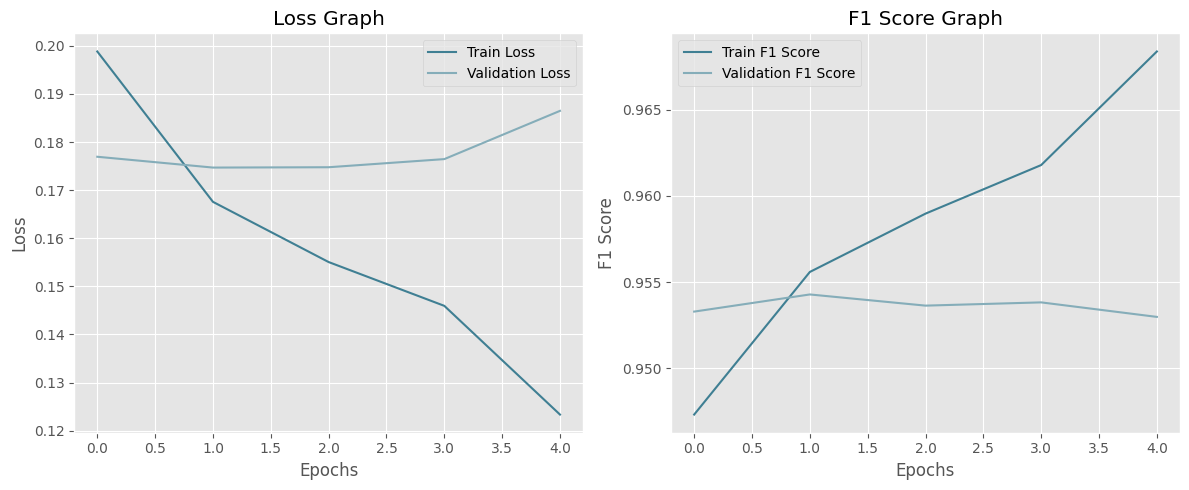

In [42]:
plot_training_history(result)

7553/7553 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - f1_score_metric: 0.9517 - loss: 0.1907
Test F1 Score: 0.9519 | Loss: 0.1896
7553/7553 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step


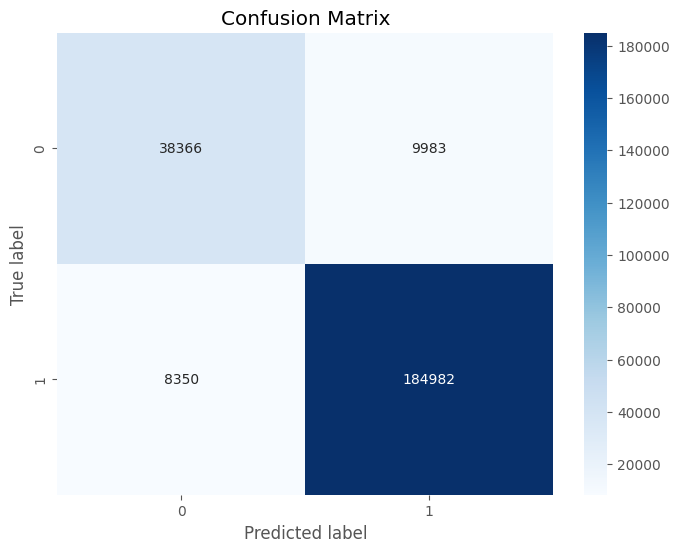

In [44]:
evaluate_lstm_model(lstm_model, X_test_processed, y_test)

### 5.2.6. Prediction

The LSTM model has successfully passed the tests conducted during the prediction phase.

In [45]:
sample_reviews = [
    "This moisturizer leaves my skin feeling soft and hydrated all day!",
    "The fragrance of this product is overwhelming and gave me a headache.",
    "This album is an absolute masterpiece with every track hitting perfectly!",
    "The sound quality of this download was terrible, full of glitches and skips.",
    "This toothbrush is amazing, my teeth feel professionally cleaned every time.",
    "The packaging was damaged, and the product was unusable upon arrival.",
]
sample_reviews_df = pd.DataFrame(sample_reviews, columns=["text"])
df_samples_clean_list = pd.Series(sample_reviews_df["text"]).tolist()

100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23899.17it/s]


In [46]:
sentiment_predictions = []
for review in df_samples_clean_list:
    sentiment = sentiment_cnn_lstm_att_predict(review, lstm_model, tokenizer, pad_seq_max_len)
    sentiment_predictions.append(sentiment)

sample_reviews_df["sentiment"] = sentiment_predictions
sample_reviews_df

,text,sentiment
0,this moisturizer leaves my skin feeling soft and hydrated all day,positive
1,the fragrance of this product is overwhelming and gave me a headache,negative
2,this album is an absolute masterpiece with every track hitting perfectly,positive
3,the sound quality of this download was terrible full of glitches and skips,negative
4,this toothbrush is amazing my teeth feel professionally cleaned every time,positive
5,the packaging was damaged and the product was unusable upon arrival,negative


# 6. Store Performance Analysis Based on Sentiment Analysis


In this section, the analysis of the best-performing stores will be conducted using sentiment analysis data. Since the store data is contained in the metadata, the metadata was loaded first. Then, the review dataset was loaded again, and the created model was used to predict sentiment, generating the sentiment feature.

The two datasets were merged based on the `category` and `parent_asin` features using a left join, resulting in a single dataset.

A score metric was created using the following features in the dataset: average review rating, review count, and sentiment column. This metric calculates the store performance by multiplying the average rating by the review count and adding a sentiment score as a penalty. The values in the sentiment column were converted to 1 for positive and -1 for negative. This way, positive reviews provide a reward, while negative reviews reduce the score, acting as a penalty.

### Formula for Store Score:
$$
\text{store\_score} = (\text{average\_rating} \times \text{rating\_number}) + (\text{sentiment\_score} \times \text{rating\_number})
$$

Using this `store_score` metric, the top 20 stores overall and the top 5 stores per category were visualized.


**Loading from Local**

In [32]:
all_beauty_meta_file_path = "./data/all_beauty/meta_All_Beauty.jsonl.gz"
digital_music_meta_file_path = "./data/digital_music/meta_Digital_Music.jsonl.gz"
health_and_personal_care_meta_file_path = "./data/health_and_personal_care/meta_Health_and_Personal_Care.jsonl.gz"

all_beauty_meta_df = pd.read_json(all_beauty_meta_file_path, lines=True, compression="gzip")
digital_music_meta_df = pd.read_json(digital_music_meta_file_path, lines=True, compression="gzip")
health_and_personal_care_meta_df = pd.read_json(health_and_personal_care_meta_file_path, lines=True,compression="gzip")

all_beauty_meta_df["category"] = "all_beauty"
digital_music_meta_df["category"] = "digital_music"
health_and_personal_care_meta_df["category"] = "health_and_personal_care"

print("# Missing value check of each dataset:\n")
meta_names = ["all_beauty_meta_df", "digital_music_meta_df", "health_and_personal_care_meta_df"]
meta_dataframes = [all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df]

for name, df in zip(meta_names, meta_dataframes):
    print(f"Missing values in the {name} dataset: {df.isnull().sum().sum()}")
    print(50 * "-")

print("# Shape check of each dataset:\n")
for name, df in zip(meta_names, meta_dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print(50 * "*")
meta_data = pd.concat([all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df], axis= 0)
meta_df = meta_data.copy()

print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {meta_df.shape}")
print(50 * "*")

# Missing value check of each dataset:

Missing values in the all_beauty_meta_df dataset: 218807
--------------------------------------------------
Missing values in the digital_music_meta_df dataset: 105187
--------------------------------------------------
Missing values in the health_and_personal_care_meta_df dataset: 112396
--------------------------------------------------
# Shape check of each dataset:

Shape of the all_beauty_meta_df dataset: (112590, 15)
--------------------------------------------------
Shape of the digital_music_meta_df dataset: (70537, 15)
--------------------------------------------------
Shape of the health_and_personal_care_meta_df dataset: (60293, 15)
--------------------------------------------------
**************************************************
The datasets from three different categories have been successfully concatenated into a single dataframe.
Shape of the concatenated dataframe is (243420, 15)
************************************************

**Loading from AWS S3**

In [47]:
s3_all_beauty_meta_path = "data/all_beauty/meta_All_Beauty.jsonl.gz"
s3_digital_music_meta_path = "data/digital_music/meta_Digital_Music.jsonl.gz"
s3_health_and_personal_care_meta_path = "data/health_and_personal_care/meta_Health_and_Personal_Care.jsonl.gz"

all_beauty_meta_df = read_s3_jsonl(s3_bucket_name, s3_all_beauty_meta_path)
digital_music_meta_df = read_s3_jsonl(s3_bucket_name, s3_digital_music_meta_path)
health_and_personal_care_meta_df = read_s3_jsonl(s3_bucket_name, s3_health_and_personal_care_meta_path)

all_beauty_meta_df["category"] = "all_beauty"
digital_music_meta_df["category"] = "digital_music"
health_and_personal_care_meta_df["category"] = "health_and_personal_care"

print("# Missing value check of each dataset:\n")
meta_names = ["all_beauty_meta_df", "digital_music_meta_df", "health_and_personal_care_meta_df"]
meta_dataframes = [all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df]

for name, df in zip(meta_names, meta_dataframes):
    print(f"Missing values in the {name} dataset: {df.isnull().sum().sum()}")
    print(50 * "-")

print("# Shape check of each dataset:\n")
for name, df in zip(meta_names, meta_dataframes):
    print(f"Shape of the {name} dataset: {df.shape}")
    print(50 * "-")

print(50 * "*")
meta_data = pd.concat([all_beauty_meta_df, digital_music_meta_df, health_and_personal_care_meta_df], axis= 0)
meta_df = meta_data.copy()

print("The datasets from three different categories have been successfully concatenated into a single dataframe.")
print(f"Shape of the concatenated dataframe is {meta_df.shape}")
print(50 * "*")

# Missing value check of each dataset:

Missing values in the all_beauty_meta_df dataset: 218807
--------------------------------------------------
Missing values in the digital_music_meta_df dataset: 105187
--------------------------------------------------
Missing values in the health_and_personal_care_meta_df dataset: 112396
--------------------------------------------------
# Shape check of each dataset:

Shape of the all_beauty_meta_df dataset: (112590, 15)
--------------------------------------------------
Shape of the digital_music_meta_df dataset: (70537, 15)
--------------------------------------------------
Shape of the health_and_personal_care_meta_df dataset: (60293, 15)
--------------------------------------------------
**************************************************
The datasets from three different categories have been successfully concatenated into a single dataframe.
Shape of the concatenated dataframe is (243420, 15)
************************************************

**Selection of Necessary Columns**

In [48]:
meta_df = meta_df[["parent_asin","main_category","category","average_rating","rating_number","store"]]

**Premium Beauty category will be added to the All Beauty category**

In [49]:
meta_df["main_category"].value_counts()

main_category
All Beauty                112135
Digital Music              70537
Health & Personal Care     60293
Premium Beauty               455
Name: count, dtype: int64

In [50]:
meta_df["category"].value_counts()

category
all_beauty                  112590
digital_music                70537
health_and_personal_care     60293
Name: count, dtype: int64

In [51]:
meta_df["main_category"] = meta_df["main_category"].replace("Premium Beauty", "All Beauty")
meta_df["main_category"].value_counts()

main_category
All Beauty                112590
Digital Music              70537
Health & Personal Care     60293
Name: count, dtype: int64

**main_category will be drop because it is identical to the category feature**

In [52]:
meta_df.drop("main_category", axis=1, inplace=True)

**Stores will be evaluated based on the store feature, Therefore missing values will be removed from this feature**

In [53]:
meta_df.isnull().sum()

parent_asin           0
category              0
average_rating        0
rating_number         0
store             17473
dtype: int64

In [54]:
meta_df.dropna(axis=0, inplace = True)

**Processing and Prediction will be performed on whole review df, and sentiment feature will be created based on the predictions**

This time, duplicate values are not removed, and the original data is preserved. In the previous case, identical reviews were removed to prevent them from negatively affecting the model's performance.



In [55]:
lstm_model = load_model(
    "model/best_lstm_model.keras",
    custom_objects={"f1_score_metric": f1_score_metric}
)

In [ ]:
df = data.copy()
df = df[["parent_asin", "rating", "text", "category"]]

df_clean_list = pd.Series(df["text"]).tolist()

sentiment_predictions = []
for review in df_clean_list:
    sentiment = sentiment_cnn_lstm_att_predict(review, lstm_model, tokenizer, maxlen)
    sentiment_predictions.append(sentiment)

df["sentiment"] = sentiment_predictions
df.head()

100%|██████████████████████████████████████████████████████████████████████████| 1326083/1326083 [00:24<00:00, 54599.32it/s]


**Meta and review dataframes have been merged into a single dataframe on parent_asin and category columns**

In [51]:
meta_df.head()

,parent_asin,category,average_rating,rating_number,store
0,B01CUPMQZE,all_beauty,4.80,10,Howard Products
1,B076WQZGPM,all_beauty,4.50,3,Yes To
2,B000B658RI,all_beauty,4.40,26,Levine Health Products
3,B088FKY3VD,all_beauty,3.10,102,Cherioll
4,B07NGFDN6G,all_beauty,4.30,7,Precision


In [52]:
df.drop("text", axis=1, inplace=True)
df.head()

,parent_asin,rating,category,sentiment
0,B00YQ6X8EO,5,all_beauty,positive
1,B081TJ8YS3,4,all_beauty,positive
2,B097R46CSY,5,all_beauty,positive
3,B09JS339BZ,1,all_beauty,negative
4,B08BZ63GMJ,5,all_beauty,positive


In [53]:
all_df = meta_df.merge(df, on=["parent_asin","category"], how="left")
print(f"Review df shape: {df.shape}, Meta df shape: {meta_df.shape}, All df shape: {all_df.shape}")
all_df.head()

Review df shape: (1308665, 4), Meta df shape: (225947, 5), All df shape: (1240931, 7)


,parent_asin,category,average_rating,rating_number,store,rating,sentiment
0,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
1,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
2,B01CUPMQZE,all_beauty,4.80,10,Howard Products,4.00,positive
3,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
4,B01CUPMQZE,all_beauty,4.80,10,Howard Products,4.00,positive


In [56]:
all_df.isnull().sum()

parent_asin         0
category            0
average_rating      0
rating_number       0
store               0
rating            525
sentiment         525
dtype: int64

In [57]:
all_df.dropna(axis=0, inplace=True)

In [59]:
all_df.head()

,parent_asin,category,average_rating,rating_number,store,rating,sentiment
0,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
1,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
2,B01CUPMQZE,all_beauty,4.80,10,Howard Products,4.00,positive
3,B01CUPMQZE,all_beauty,4.80,10,Howard Products,5.00,positive
4,B01CUPMQZE,all_beauty,4.80,10,Howard Products,4.00,positive


In [90]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1240406 entries, 0 to 1240930
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   parent_asin      1240406 non-null  object 
 1   category         1240406 non-null  object 
 2   average_rating   1240406 non-null  object 
 3   rating_number    1240406 non-null  object 
 4   store            1240406 non-null  object 
 5   rating           1240406 non-null  float64
 6   sentiment        1240406 non-null  object 
 7   sentiment_score  1240406 non-null  int32  
 8   store_score      1240406 non-null  object 
dtypes: float64(1), int32(1), object(7)
memory usage: 89.9+ MB


In [107]:
# Type checking and converting into related types
all_df["rating_number"] = all_df["rating_number"].astype(int)
all_df["average_rating"] = all_df["average_rating"].astype(int)

In [108]:
# Create sentiment scores (1 for positive, -1 for negative)
all_df["sentiment_score"] = np.where(all_df["sentiment"]=="positive", 1, -1)

In [111]:
# Calculate store_score for each seller
all_df["store_score"] = (all_df["average_rating"] * all_df["rating_number"]) + (all_df["sentiment_score"] * all_df["rating_number"])

In [112]:
# Group by store and calculate the total store_score for each seller
store_scores = all_df.groupby("store")["store_score"].sum().reset_index()

In [113]:
# Sort the stores by store_score and select the top 20
sorted_stores = store_scores.sort_values(by="store_score", ascending=False).head(20)

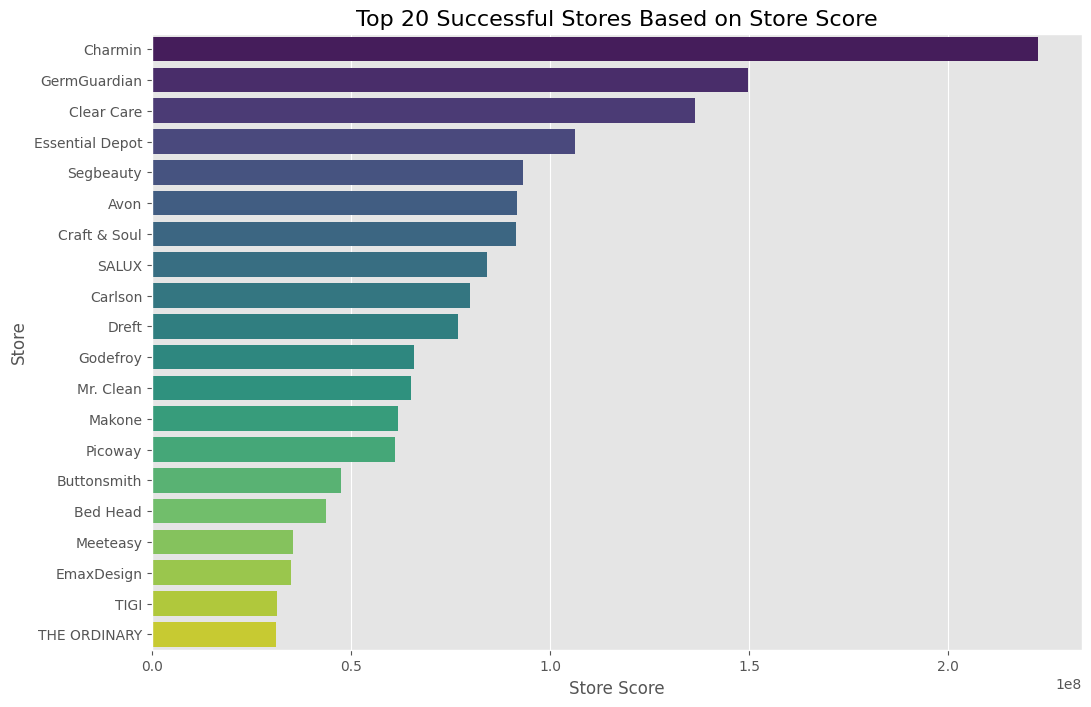

In [114]:
# Plot the top 20 stores with the highest store scores
plt.figure(figsize=(12, 8))
sns.barplot(x="store_score", y="store", data=sorted_stores, palette="viridis")
plt.title("Top 20 Successful Stores Based on Store Score", fontsize=16)
plt.xlabel("Store Score", fontsize=12)
plt.ylabel("Store", fontsize=12)
plt.show()

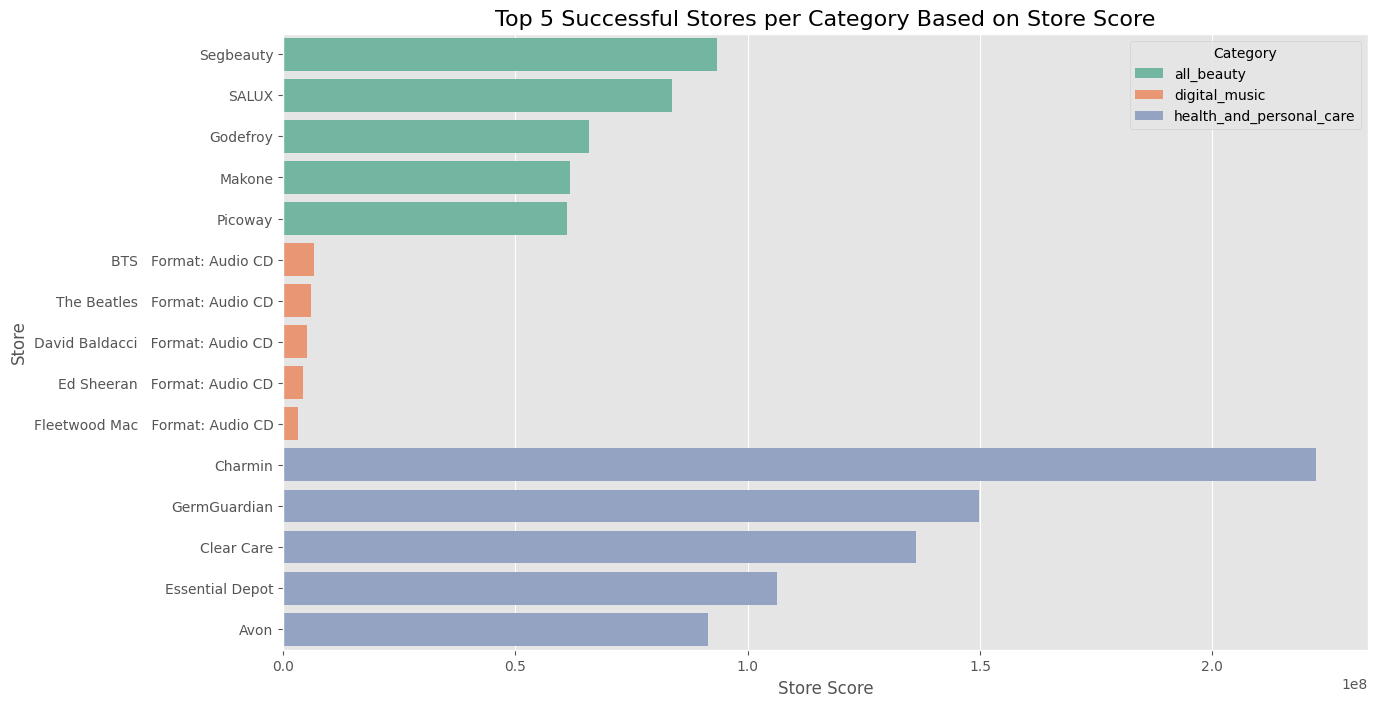

In [ ]:
# Top 5 store per Category
store_scores_category = all_df.groupby(["store", "category"])["store_score"].sum().reset_index()
top_5_per_category = store_scores_category.groupby("category").apply(lambda x: x.nlargest(5, "store_score")).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(x='store_score', y='store', hue='category', data=top_5_per_category, palette='Set2')
plt.title('Top 5 Successful Stores per Category Based on Store Score', fontsize=16)
plt.xlabel('Store Score', fontsize=12)
plt.ylabel('Store', fontsize=12)
plt.legend(title='Category')
plt.show()


# 7. Conclusion

In terms of performance, logistic regression achieved 91% accuracy, while the deep learning model with LSTM and a self-attention mechanism achieved 95% accuracy. However, logistic regression is significantly faster in terms of processing time. Adjusting the n-gram ranges might potentially improve the accuracy further. If this model is to be deployed in a live environment, using logistic regression could be more advantageous due to its speed and efficiency.

In this study, sentiment analysis was performed using Amazon reviews. A Logistic Regression model and deep learning model with LSTM and a self-attention mechanism were trained. Sentiment columns were created from the predictions, and successful sellers were analyzed. 

A score metric was created using the following features in the dataset: average review rating, review count, and sentiment column. This metric calculates the store performance by multiplying the average rating by the review count and adding a sentiment score as a penalty. The values in the sentiment column were converted to 1 for positive and -1 for negative. This way, positive reviews provide a reward, while negative reviews reduce the score, acting as a penalty.

The top 20 stores with the highest store scores were determined. These stores have shown consistent success in terms of their ratings and sentiments. The results indicate that these stores are likely to attract more customers and increase their sales volume.

Furthermore, the study analyzed the top 5 successful stores per category. It found that the stores in the "Healt and Personal Care" category have consistently shown high store scores, while the stores in the "Digital Music" category have lower scores. This could be due to the limited reviews available for these categories or the different customer preferences and needs of the respective products.

Overall, sentiment analysis using Amazon reviews can provide valuable insights into customer preferences and the success of e-commerce stores. By analyzing sentiments, ratings, and store performance, businesses can make data-driven decisions to improve their customer experiences and increase their overall revenue.

